<a href="https://www.kaggle.com/code/sonujha090/tempered-image-detection-pytorch?scriptVersionId=111922949" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Aim: To Build a deep learning algorithm which can detect whether an Image is Original or Tempered

Many images are spread in the virtual world of social media. With the many editing software that allows so there is no doubt that many forgery images. By forensic the image using Error Level Analysis to find out the compression ratio between the original image and the fake image, because the original image compression and fake images are different. In addition to knowing whether the image is genuine or fake can analyze the metadata of the image, but the possibility of metadata can be changed.

`image forensic is a field of the study identifying the origin and verifying the authenticity of the image.`

Many methods are used to determine the level of authenticity of the picture, one with determining the quality of the image compression level results. Here, the methods used to measure the level of compression is using `Error Level Analysis (ELA).`

`Error level analysis` is one technique for knowing images that have been manipulated by storing images at a certain quality level and then calculating the difference from the compression level.

In [1]:
# converting image to ela image
from glob import glob 
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import os 

# EDA

In [2]:
total_files = glob("../input/casia-dataset/CASIA2/**/*")
print('total files', len(total_files))

# types of files
types = set()
for file in total_files:
    types.add(file.split(".")[-1])
print('types of files in the folder', types)

# jpg files
jpg_files = glob("../input/casia-dataset/CASIA2/*/*.jpg")
print('jpg files: ', len(jpg_files))

#tif files
tif_files = glob("../input/casia-dataset/CASIA2/**/*.tif")
print('tif files: ', len(tif_files))

#TOTAL jpg file whose name starts with Tp
tp_jpg_files = glob("../input/casia-dataset/CASIA2/**/Tp*")
print('tp_jpg_files: ', len(tp_jpg_files))
print('first 5 tp_jpg_files: ', tp_jpg_files[:5])

total files 12616
types of files in the folder {'bmp', 'jpg', 'JPG', 'tif', 'db'}
jpg files:  9418
tif files:  3059
tp_jpg_files:  5123
first 5 tp_jpg_files:  ['../input/casia-dataset/CASIA2/Tp/Tp_D_NRN_M_N_nat00025_nat00028_11037.jpg', '../input/casia-dataset/CASIA2/Tp/Tp_S_NND_S_N_arc00012_arc00012_01111.tif', '../input/casia-dataset/CASIA2/Tp/Tp_S_NRN_S_N_art20038_art20038_01844.tif', '../input/casia-dataset/CASIA2/Tp/Tp_S_NRN_S_N_art00092_art00092_11809.jpg', '../input/casia-dataset/CASIA2/Tp/Tp_S_NNN_S_N_txt00060_txt00060_01282.tif']


# Data Preprocessing

This function will convert the images to ELA images, If we use original image without extacting ELA image it will have veryy low score. 

In [3]:
def convert_to_ela_image(image_path, quality=90):
    # Save the image at the given quality
    temp_file = 'temp.jpg'
    im = Image.open(image_path).convert('RGB')
    im.save(temp_file, 'JPEG', quality=quality)

    # Open the saved image and the original image
    saved = Image.open(temp_file)
    orignal = Image.open(image_path)

    # Find the absolute difference between the images
    diff = ImageChops.difference(orignal, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff
    diff = ImageEnhance.Brightness(diff).enhance(scale)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

**Collect all the images**

In [4]:
images = jpg_files
print('jpeg files', len(images))
images.extend(tif_files)
print('total images', len(images))

jpeg files 9418
total images 12477


**Checking total number of Authentics image and Tempered images**

In [5]:
# find the number of files whose name starts with Tp in a list 
def find_tp_files(files):
    tp_files, au_files = 0, 0
    for file in files:
        if file.split("/")[-1].split("_")[0] == 'Tp':
            tp_files += 1
        if file.split("/")[-1].split("_")[0] == "Au":
            au_files += 1
    return tp_files, au_files
find_tp_files(images)

(5123, 7354)

# ELA images

In [6]:
# converting images to ela images
for image in tqdm(images[:11957]):
    # converting image to ela image
    ela_image = convert_to_ela_image(image)
    # creating a new directory for ela images
    if not os.path.exists('/CASIA2_ELA'):
        os.mkdir('/CASIA2_ELA')
#     print('/CASIA2_ELAtp/' + image.split('/')[-1])
    ela_image.save('/CASIA2_ELA/' + image.split('/')[-1])

100%|██████████| 11957/11957 [06:31<00:00, 30.57it/s]


In [7]:
# types of files
total_files = glob('/CASIA2_ELA/*')
print('total els files', len(total_files))
types = set()
for file in total_files:
    types.add(file.split(".")[-1])
print('types of files in the folder', types)

total els files 11957
types of files in the folder {'tif', 'jpg'}


In [8]:
find_tp_files(total_files)

(4603, 7354)

# UTILS

**Once again we will check total number of authentic and tempered images**

In [9]:
# counting the number of each class in the dataset
def count_classes(dataloader):
    tempered, original = 0, 0
    for images, labels in tqdm(dataloader):
        for label in labels:
            if label == 1:
                tempered += 1
            else:
                original += 1
    print(f"Tempered: {tempered}, Original: {original}")

# Creating Custom PyTorch DataLoader

In [10]:
# importing the datasets 
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from glob import glob
from torchvision import transforms
from PIL import Image
import torch 
import random

# creating a class for the dataset
class CASIA2_ELA(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = image.split("/")[-1].split("_")[0]
        label = 1 if label == 'Tp' else 0
        image = Image.open(image)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)

# testing the dataset
def test():
    all_images = glob("/CASIA2_ELA/*")
    random.shuffle(all_images)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    dataset = CASIA2_ELA(all_images, transform=transform)
    print(dataset[1][0].shape)
    print(dataset[1][1])

# if __name__ == "__main__":
#     test()

In [11]:
from torchvision import models
from torch import nn, optim
import random 
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_images = glob("/CASIA2_ELA/*.jpg")
# shuffle the images
random.shuffle(all_images)

all_images = glob("/CASIA2_ELA/*")
random.shuffle(all_images)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = CASIA2_ELA(all_images, transform=transform)

**Since dataset is biased therefore we will use stratify cross validation, it will make sure the train and valid dataset contain same both the labels into same ration.**

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

def split_dataset(dataset, train_size=0.8):
    # get the indices of the images
    indices = list(range(len(dataset)))
    # get the labels of the images
    labels = [dataset[i][1] for i in indices]
    # split the indices into train and validation indices
    train_indices, val_indices, train_labels, val_labels = train_test_split(indices, labels, train_size=train_size, stratify=labels)
    # create the train and validation subsets
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset, val_dataset

In [13]:
%time train_ds, valid_ds = split_dataset(dataset)

CPU times: user 43.7 s, sys: 726 ms, total: 44.4 s
Wall time: 44.8 s


In [14]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dataset = DataLoader(valid_ds, batch_size=32, shuffle=False)

`Once again we will check the label ration on train and valid dataloader`

In [15]:
count_classes(train_loader)

100%|██████████| 299/299 [00:39<00:00,  7.56it/s]

Tempered: 3682, Original: 5883


In [16]:
count_classes(val_dataset)

100%|██████████| 75/75 [00:09<00:00,  8.14it/s]

Tempered: 921, Original: 1471


# Visualizing

In [17]:
import matplotlib.pyplot as plt 
def visualize(dataloader):
    for images, labels in dataloader:
        print(images.shape)
        print(labels.shape)
        plt.figure(figsize=(16, 8))
        for i in range(32):
            plt.subplot(4, 8, i+1)
            plt.imshow(images[i].permute(1, 2, 0))
            plt.title(f"Label: {labels[i]}")
            plt.axis("off")
        plt.show()
        break

torch.Size([32, 3, 224, 224])
torch.Size([32])


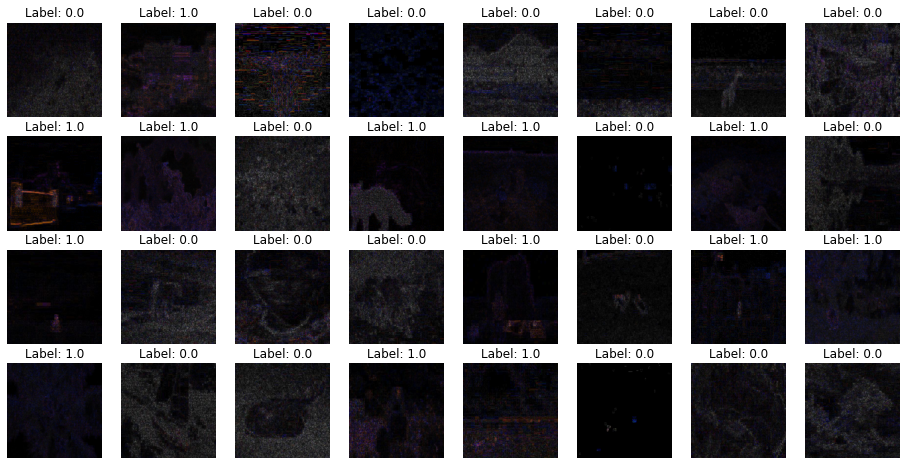

In [18]:
visualize(train_loader)

# Model

**First we are gonna try a simple tiny CNN just to have a benchmark**

In [19]:
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(774400, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        out = nn.Sigmoid()
        return out(x)
    
model = CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=774400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

# Training Function

In [20]:
# define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**Testing training loop**

**To check our training procedure and visualize if everything is working correctly, we will take a small subset of data and see the trainig progress.**

In [21]:
train_sub = Subset(train_ds, range(2000))
train_sub_dl = DataLoader(train_sub, batch_size=32, shuffle=True)

In [23]:
from sklearn.metrics import f1_score
losses = []
accuracy = []
for epch in range(5):
    for xb, yb in tqdm(train_sub_dl):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        yb_ = model(xb)
        loss = criterion(yb_.squeeze(1), yb)
        losses.append(loss.item())
        batch_acc = f1_score(yb.cpu().detach().numpy(), yb_.cpu().detach().numpy().round(), )
        accuracy.append(batch_acc)
        loss.backward()
        optimizer.step()

100%|██████████| 63/63 [00:10<00:00,  5.83it/s]


**I took a subset of train dataset contain 2000 images and train it for 5 epoch and now I'll check the progreess of loss and accuracy**

Since dataset is biased so accuracy won't be the perfect metrics to judge it, therefore I've selected f1_score as a metric

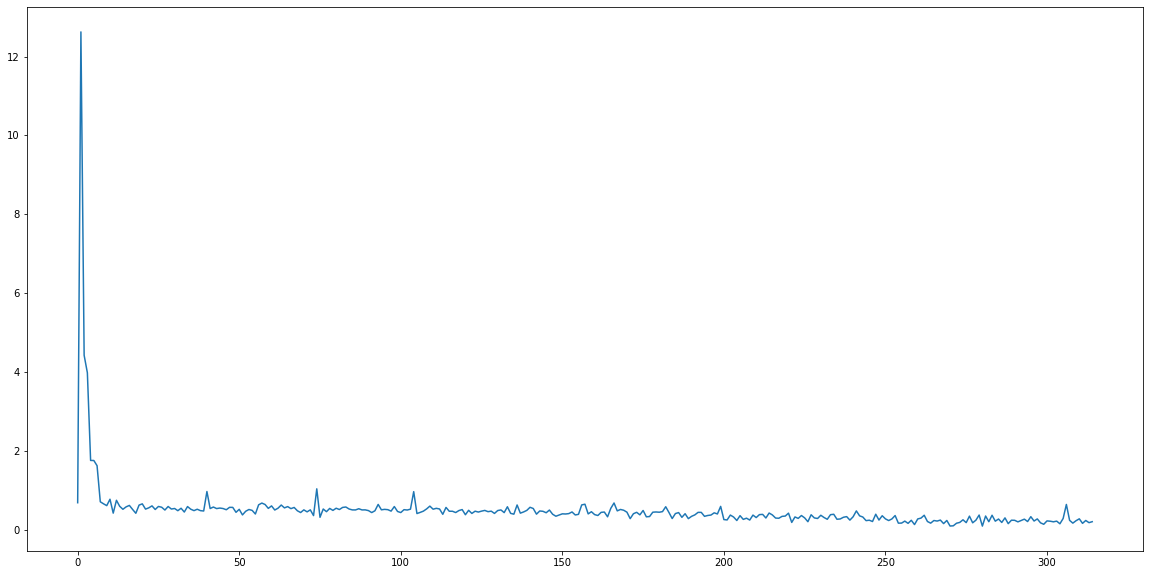

In [25]:
plt.figure(figsize = (20, 10))
plt.plot(losses)

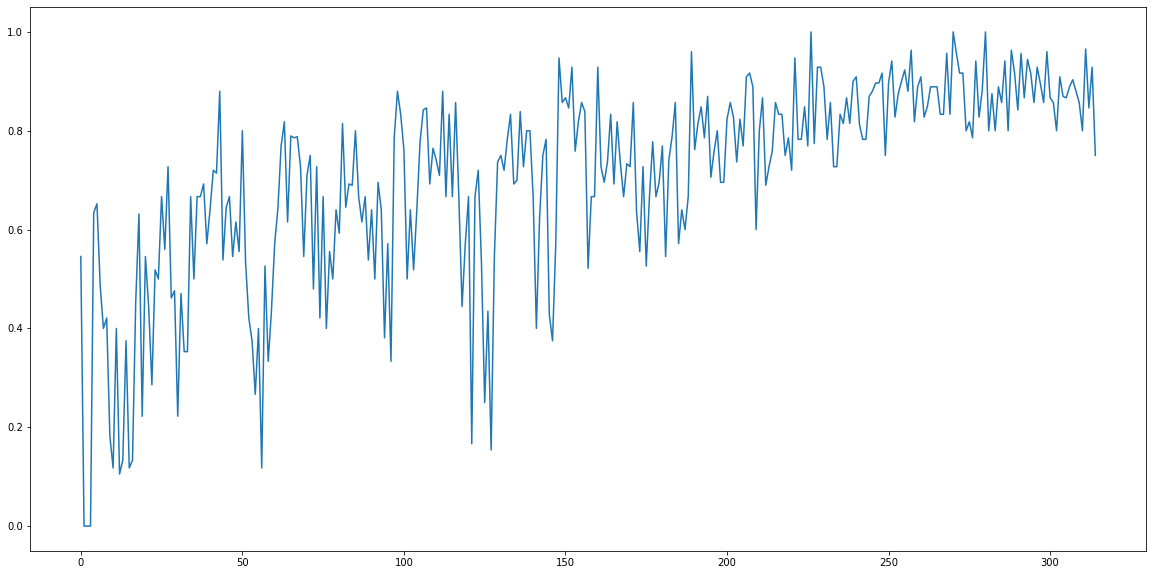

In [26]:
plt.figure(figsize = (20, 10))
plt.plot(accuracy)

**As you can see everything is working correctly, the loss keep decreasing and f1_score is increaseing, now we are good for training.**

# Training the model

In [27]:
from sklearn.metrics import accuracy_score, f1_score

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        for xb, yb in tqdm(train_loader):
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            yb_ = model(xb)
            loss = criterion(yb_.squeeze(1), yb)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            batch_acc = accuracy_score(yb.cpu().detach().numpy(), yb_.cpu().detach().numpy().round())
            train_acc.append(batch_acc)
        model.eval()
        with torch.no_grad():
            for xb, yb in tqdm(val_loader):
                xb, yb = xb.to(device), yb.to(device)
                yb_ = model(xb)
                loss = criterion(yb_.squeeze(1), yb)
                val_loss.append(loss.item())
                batch_acc = accuracy_score(yb.cpu().detach().numpy(), yb_.cpu().detach().numpy().round())
                val_acc.append(batch_acc)
        print(f'Epoch: {epoch+1}, Train Loss: {torch.tensor(train_loss).mean():.4f}, Train Accuracy: {torch.tensor(train_acc).mean():.4f}, Val Loss: {torch.tensor(val_loss).mean():.4f}, Val Accuracy: {torch.tensor(val_acc).mean():.4f}')

In [28]:
train_model(model, train_loader, val_dataset, criterion, optimizer, num_epochs=5, device=device)

100%|██████████| 75/75 [00:12<00:00,  6.08it/s]


Epoch: 1, Train Loss: 0.3475, Train Accuracy: 0.8623, Val Loss: 0.3225, Val Accuracy: 0.8688


100%|██████████| 75/75 [00:12<00:00,  6.04it/s]


Epoch: 2, Train Loss: 0.3243, Train Accuracy: 0.8700, Val Loss: 0.3288, Val Accuracy: 0.8652


100%|██████████| 75/75 [00:12<00:00,  5.97it/s]


Epoch: 3, Train Loss: 0.2835, Train Accuracy: 0.8856, Val Loss: 0.3393, Val Accuracy: 0.8609


100%|██████████| 75/75 [00:12<00:00,  6.00it/s]


Epoch: 4, Train Loss: 0.2535, Train Accuracy: 0.8972, Val Loss: 0.3487, Val Accuracy: 0.8594


100%|██████████| 75/75 [00:12<00:00,  5.92it/s]

Epoch: 5, Train Loss: 0.2299, Train Accuracy: 0.9065, Val Loss: 0.3626, Val Accuracy: 0.8591


# Prediction on a single image

**Saving and Loading Model**

In [29]:
# Specify a path to save to
PATH = "cnn.pth"

# Save
torch.save(model.state_dict(), PATH)

In [31]:
device = torch.device('cpu')
model = CNN()
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

**If we want to predict an image, we have to transform it in the same manner as validation dataset**

In [32]:
# model
import torchvision, torch
from torchvision import transforms

    
# predict
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def predict_image(image_path, model):
    # converting image to ela image
    img = convert_to_ela_image(image_path)
    # apply transform
    img = transform(img)
    # creating shape in 4d like 1 batch of dataset
    img = img.unsqueeze(0)
    # model in evalutiaon mode 
    model.eval()
    # prediction 
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
    return 'fake' if pred.item() == 1 else 'real'

total images:  790


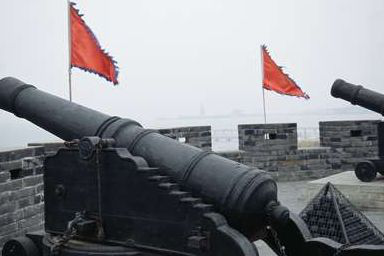

In [33]:
from glob import glob
images = glob('../input/casia-dataset/CASIA1/Au/*.jpg')
print('total images: ', len(images))
img1 = images[0]
img = Image.open(img1)
img

In [34]:
result = predict_image(img1, model)
print(result)

real


`This is just a basic benchmark model, there is still a lot of scope to improve this model, we can try larger network, transfer learning, data augmentation etc`

Reference: https://www.researchgate.net/publication/332561655_Image_forgery_detection_using_error_level_analysis_and_deep_learning

Don't forget to upvote this notebook if you find it helpful